# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Convert feature percentages to stdev
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))

def from_file(symbol):
    dataset_path = keras.utils.get_file("{}.csv".format(symbol), "http://localhost:8000/data/daily/{}.csv".format(symbol))
    column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
    return pd.read_csv(dataset_path, 
                              names=column_names, 
                              dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                              header=0,
                              na_values = "?", 
                              comment='\t',
                              sep=",",
                              skipinitialspace=True)

#dataset = raw_dataset.copy()
dataset = from_network('SPY')
dataset = dataset.sort_values(by=['Date'],ascending=False)




In [2]:
print dataset

                  High         Low        Open       Close       Volume  \
Date                                                                      
2019-01-22  265.059998  261.059998  264.820007  262.859985  115355500.0   
2019-01-18  266.980011  263.000000  264.980011  266.459991  127900300.0   
2019-01-17  263.920013  259.959991  260.010010  262.959991   96118400.0   
2019-01-16  261.970001  260.600006  260.829987  260.980011   77636700.0   
2019-01-15  260.700012  257.809998  257.820007  260.350006   85208300.0   
2019-01-14  258.299988  256.410004  256.859985  257.399994   70908200.0   
2019-01-11  259.010010  257.029999  257.679993  258.980011   73858100.0   
2019-01-10  259.160004  255.500000  256.260010  258.880005   96823900.0   
2019-01-09  258.910004  256.190002  257.559998  257.970001   95006600.0   
2019-01-08  257.309998  254.000000  256.820007  256.769989  102512600.0   
2019-01-07  255.949997  251.690002  252.690002  254.380005  103139100.0   
2019-01-04  253.110001  2

In [3]:

dataset_stats = dataset.describe()
dataset_stats = dataset_stats.transpose()
NUM_INPUT_NEURONS = 64
NUM_OUTPUT_NEURONS = 1
NUM_SAMPLES = len(dataset)
NUM_TEST_SAMPLES = int(.25 * NUM_SAMPLES)
NUM_TEST_SAMPLES = 1000 # hard fixing this for now
DAY_OFFSET = 1
print NUM_SAMPLES
# Create features (only close price for now)
def convert_to_percentage(old, new):
    return (old - new) / old

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
    # return map(lambda arr: 1 if arr[0] > 1 else 0, labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,4),arr), labels)

def convert_to_train(raw_dataset):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(DAY_OFFSET, len(dataset) - NUM_INPUT_NEURONS):

        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        features.append(
            feature_dataset['Close']
                .map(lambda current: convert_to_percentage(latest_close, current))
                .tolist()
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Close'].iloc[i-2] / latest_close, # 2 day trade
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['Close'].iloc[i-4] / latest_close, # 4 day trade
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]
converted_feature_set = convert_to_train(dataset)
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(converted_feature_set[0][0])]),
    layers.Dense(32, kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001), activation=tf.nn.relu),
    layers.Dense(16, kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(loss='mse',
                optimizer='sgd',
                metrics=[
                    'mae',
                ])
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

6542
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [4]:
#len(converted_feature_set[0][0])
print NUM_TEST_SAMPLES
train_data = np.array(converted_feature_set[0][NUM_TEST_SAMPLES:])
train_labels = np.array(converted_feature_set[1][NUM_TEST_SAMPLES:])

test_data = np.array(converted_feature_set[0][:NUM_TEST_SAMPLES])
test_labels = np.array(converted_feature_set[1][:NUM_TEST_SAMPLES])


1000


In [5]:
print train_data
print train_labels

[[ 0.          0.0091589  -0.00371306 ...  0.01292143  0.0192089
   0.01772366]
 [ 0.         -0.01299094 -0.02653142 ...  0.01014289  0.00864393
   0.01988606]
 [ 0.         -0.01336683 -0.01099929 ...  0.02135741  0.03245537
   0.03112367]
 ...
 [ 0.          0.00280309  0.00630583 ... -0.00840926 -0.00911114
  -0.00490651]
 [ 0.          0.00351259  0.00983838 ... -0.01194772 -0.00773127
   0.00281097]
 [ 0.          0.00634809  0.00775852 ... -0.0112835  -0.0007041
   0.00141044]]
[[0.9874]
 [1.0092]
 [0.9872]
 ...
 [0.9965]
 [1.0028]
 [1.0035]]


In [6]:

history = model.fit(
    train_data, train_labels,
    epochs=90, validation_split = 0.2, verbose=1,
    callbacks=[tensorboard]
)

Train on 4381 samples, validate on 1096 samples
Epoch 1/90
4381/4381 [==============================] - 0s 92us/step - loss: 0.1182 - mean_absolute_error: 0.1632 - val_loss: 0.0422 - val_mean_absolute_error: 0.0270
Epoch 2/90
4381/4381 [==============================] - 0s 50us/step - loss: 0.0440 - mean_absolute_error: 0.0321 - val_loss: 0.0415 - val_mean_absolute_error: 0.0141
Epoch 3/90
4381/4381 [==============================] - 0s 49us/step - loss: 0.0425 - mean_absolute_error: 0.0212 - val_loss: 0.0414 - val_mean_absolute_error: 0.0115
Epoch 4/90
4381/4381 [==============================] - 0s 45us/step - loss: 0.0420 - mean_absolute_error: 0.0177 - val_loss: 0.0413 - val_mean_absolute_error: 0.0112
Epoch 5/90
4381/4381 [==============================] - 0s 42us/step - loss: 0.0417 - mean_absolute_error: 0.0163 - val_loss: 0.0412 - val_mean_absolute_error: 0.0103
Epoch 6/90
4381/4381 [==============================] - 0s 41us/step - loss: 0.0416 - mean_absolute_error: 0.0155 - v

4381/4381 [==============================] - 0s 47us/step - loss: 0.0388 - mean_absolute_error: 0.0111 - val_loss: 0.0386 - val_mean_absolute_error: 0.0069
Epoch 50/90
4381/4381 [==============================] - 0s 41us/step - loss: 0.0388 - mean_absolute_error: 0.0111 - val_loss: 0.0386 - val_mean_absolute_error: 0.0069
Epoch 51/90
4381/4381 [==============================] - 0s 40us/step - loss: 0.0387 - mean_absolute_error: 0.0110 - val_loss: 0.0385 - val_mean_absolute_error: 0.0069
Epoch 52/90
4381/4381 [==============================] - 0s 38us/step - loss: 0.0386 - mean_absolute_error: 0.0110 - val_loss: 0.0385 - val_mean_absolute_error: 0.0069
Epoch 53/90
4381/4381 [==============================] - 0s 50us/step - loss: 0.0386 - mean_absolute_error: 0.0110 - val_loss: 0.0384 - val_mean_absolute_error: 0.0069
Epoch 54/90
4381/4381 [==============================] - 0s 39us/step - loss: 0.0385 - mean_absolute_error: 0.0110 - val_loss: 0.0383 - val_mean_absolute_error: 0.0068
Epoc

In [7]:
outputs = model.predict(test_data)

In [8]:
print test_data[0]
print test_labels[0]
print outputs[0]

[ 0.          0.01313518  0.02056587  0.02293022  0.03400134  0.02807168
  0.028447    0.03186216  0.03636569  0.04533509  0.05280339  0.08350216
  0.06109735  0.06207308  0.07021689  0.06901593  0.07610898  0.12054341
  0.09667491  0.07239358  0.0570442   0.04270806  0.04165725  0.02247989
  0.00409066  0.00375291  0.00874423  0.00896939  0.01084585 -0.01268485
 -0.01422356 -0.04818733 -0.03448924 -0.02822195 -0.0304736  -0.00728065
 -0.00390306  0.0120468   0.0054042   0.00878179 -0.00990773 -0.02728372
 -0.02461907 -0.01403596 -0.02101631 -0.02293033 -0.04240794 -0.05269087
 -0.05460489 -0.0325002  -0.02600774 -0.02037838 -0.02645807 -0.01564968
 -0.0049163   0.00975759  0.00424081 -0.01358551  0.00427826 -0.02683327
 -0.03208744 -0.03674101 -0.03730392 -0.05250327]
[0.9865]
[0.99852324]


In [9]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1 else 0,signals)

In [10]:
outputs[1:]

array([[0.9919673 ],
       [0.97902054],
       [1.0092354 ],
       [1.0114131 ],
       [1.0080316 ],
       [1.0078993 ],
       [1.0078127 ],
       [1.0144763 ],
       [0.99897987],
       [0.993247  ],
       [0.99656576],
       [0.98158044],
       [0.99007654],
       [0.9988566 ],
       [0.9911241 ],
       [0.9895513 ],
       [1.0059719 ],
       [0.99328536],
       [0.99565846],
       [1.0004785 ],
       [0.9928389 ],
       [0.9885848 ],
       [0.99270225],
       [0.99588335],
       [1.0045333 ],
       [1.0157982 ],
       [1.0077798 ],
       [1.0106407 ],
       [1.013469  ],
       [1.016728  ],
       [1.0016236 ],
       [1.003833  ],
       [0.99798954],
       [0.9882632 ],
       [0.9929999 ],
       [1.0039673 ],
       [0.99863666],
       [1.000255  ],
       [0.99660695],
       [0.99228716],
       [0.98660195],
       [0.9937797 ],
       [1.0016781 ],
       [1.0037427 ],
       [1.0027459 ],
       [1.0093601 ],
       [1.0025494 ],
       [0.998

In [11]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [12]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [13]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,0.9865,0.998523,0,0,0,1,0,1
1,1.0133,0.991967,0,0,0,0,1,1
2,1.0076,0.979021,0,0,0,0,1,1
3,1.0024,1.009235,1,1,0,0,0,1
4,1.0115,1.011413,1,1,0,0,0,1
5,0.9939,1.008032,1,0,1,0,0,0
6,1.0004,1.007899,1,1,0,0,0,1
7,1.0035,1.007813,1,1,0,0,0,1
8,1.0047,1.014476,1,1,0,0,0,1
9,1.0094,0.998980,0,0,0,0,1,1


In [14]:
print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)



Precision
0.534450651769

Recall
0.544592030361

Accuracy
0.287

Non-loss events
750
0.75

Lose trades
250
0.25

Win trades
287
0.287

Missed opportunities
240
0.24

Bullets dodged
209
0.209


In [15]:
df1 = dataset.copy().iloc[DAY_OFFSET-1:].head(NUM_TEST_SAMPLES)
df2 = df.copy()

In [16]:
pd.concat([df1.reset_index(),df2], axis=1).drop(['High','Low','Open','Volume','Adj Close'], axis=1)

,Date,Close,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,2019-01-22,262.859985,0.9865,0.998523,0,0,0,1,0,1
1,2019-01-18,266.459991,1.0133,0.991967,0,0,0,0,1,1
2,2019-01-17,262.959991,1.0076,0.979021,0,0,0,0,1,1
3,2019-01-16,260.980011,1.0024,1.009235,1,1,0,0,0,1
4,2019-01-15,260.350006,1.0115,1.011413,1,1,0,0,0,1
5,2019-01-14,257.399994,0.9939,1.008032,1,0,1,0,0,0
6,2019-01-11,258.980011,1.0004,1.007899,1,1,0,0,0,1
7,2019-01-10,258.880005,1.0035,1.007813,1,1,0,0,0,1
8,2019-01-09,257.970001,1.0047,1.014476,1,1,0,0,0,1
9,2019-01-08,256.769989,1.0094,0.998980,0,0,0,0,1,1


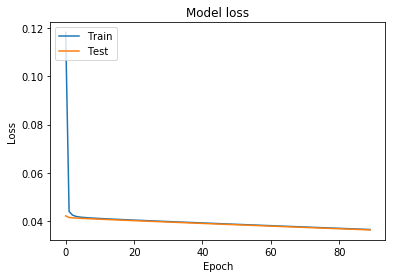

In [17]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
weights, biases = model.layers[0].get_weights()


In [19]:
list(biases)

[-0.02666942,
 0.0018169369,
 0.034502413,
 -0.0057319435,
 -0.0041202437,
 -0.016257104,
 0.011684047,
 0.01179649,
 0.024464743,
 0.030239182,
 0.041112885,
 -0.008901584,
 0.0004337082,
 -0.016547369,
 -0.015015136,
 0.013081268,
 0.031697247,
 -0.016279131,
 -0.0055901455,
 -0.02955402,
 -0.014938693,
 0.012604811,
 0.01602034,
 0.0020606383,
 0.013530555,
 0.013789249,
 0.06606103,
 -0.026706923,
 0.020914707,
 0.0130150225,
 -0.02001907,
 0.019219141,
 -0.027497623,
 0.0015115787,
 -0.024763674,
 0.010092185,
 -0.035310455,
 0.001810295,
 0.008889512,
 -0.013535828,
 -0.0007925962,
 0.018487895,
 -0.032168306,
 -0.0047229542,
 0.0025249494,
 0.01224235,
 0.0027246315,
 0.012659242,
 0.049554657,
 -0.009845141,
 0.058945764,
 -0.0050752754,
 -0.003028135,
 0.0077958144,
 -0.0061433474,
 -0.008104145,
 -0.032016978,
 -0.009150275,
 0.057086565,
 -0.010673935,
 -0.017808575,
 0.015787005,
 0.00587588,
 -0.03152272]